In [1]:
import sys 
sys.path.append('..')
import matplotlib.pyplot as plt
from glob import glob
import ra
import numpy as np
import pylab 
import scipy.stats as stats
from utils import *
import tensorflow as tf

def show_images(images, cols = 1):
    n_images = len(images)
    fig = plt.figure()
    for n, image in enumerate(images):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        plt.imshow(image, cmap='gray')
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.show()

(4, 320, 256)


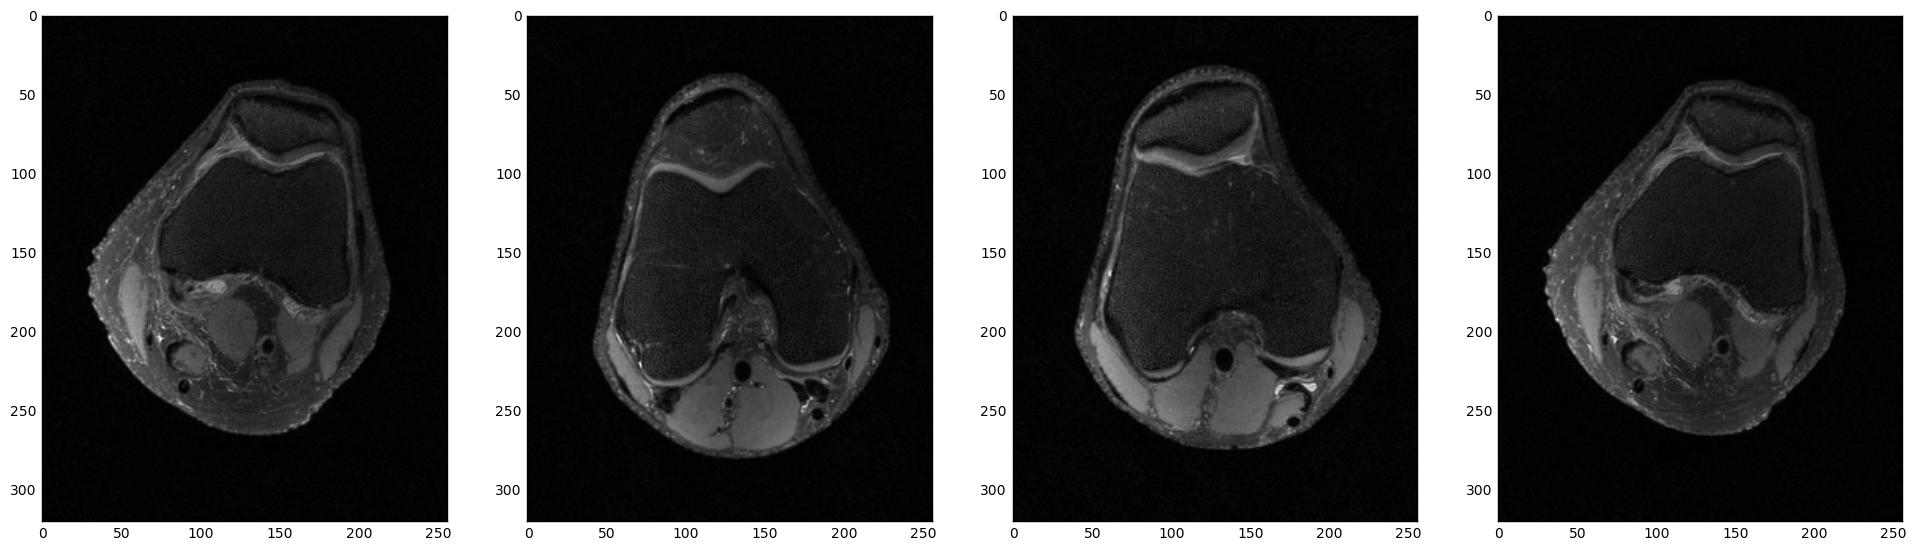

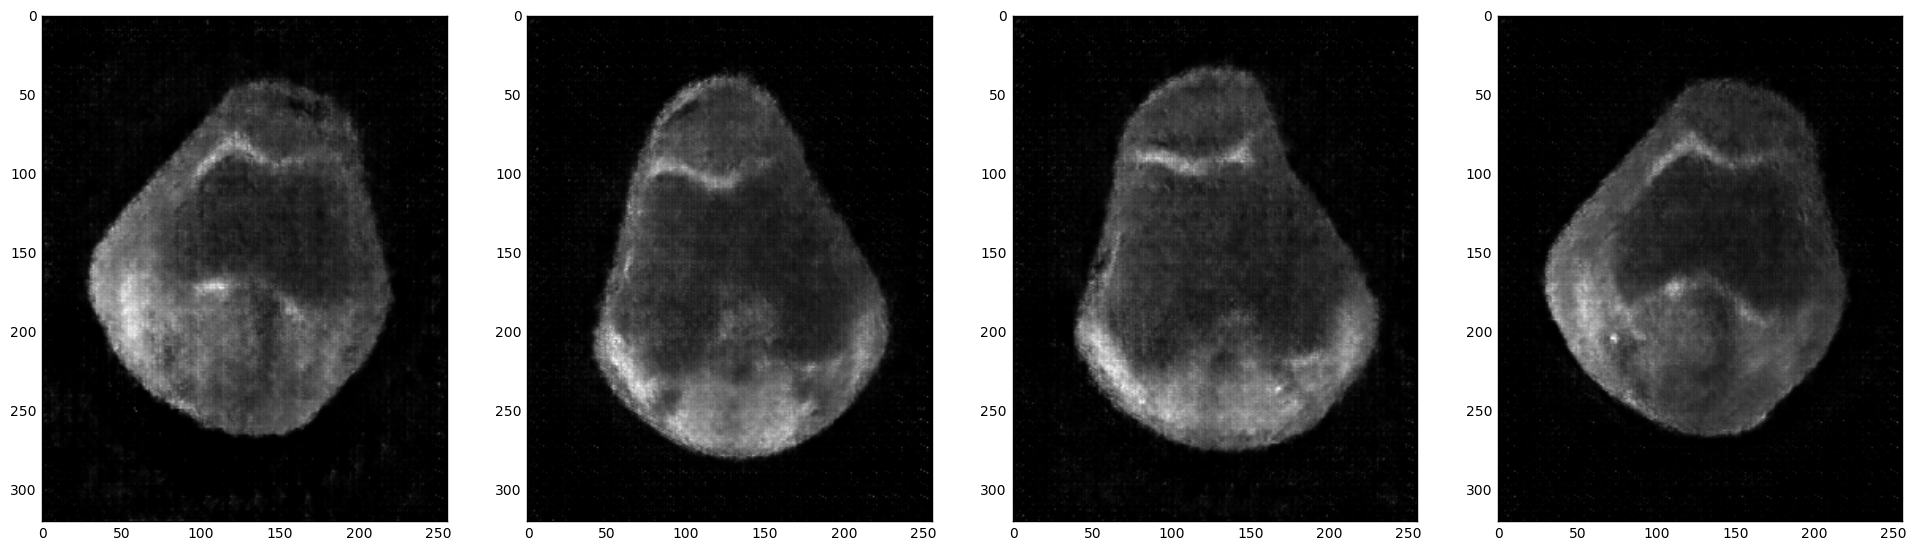

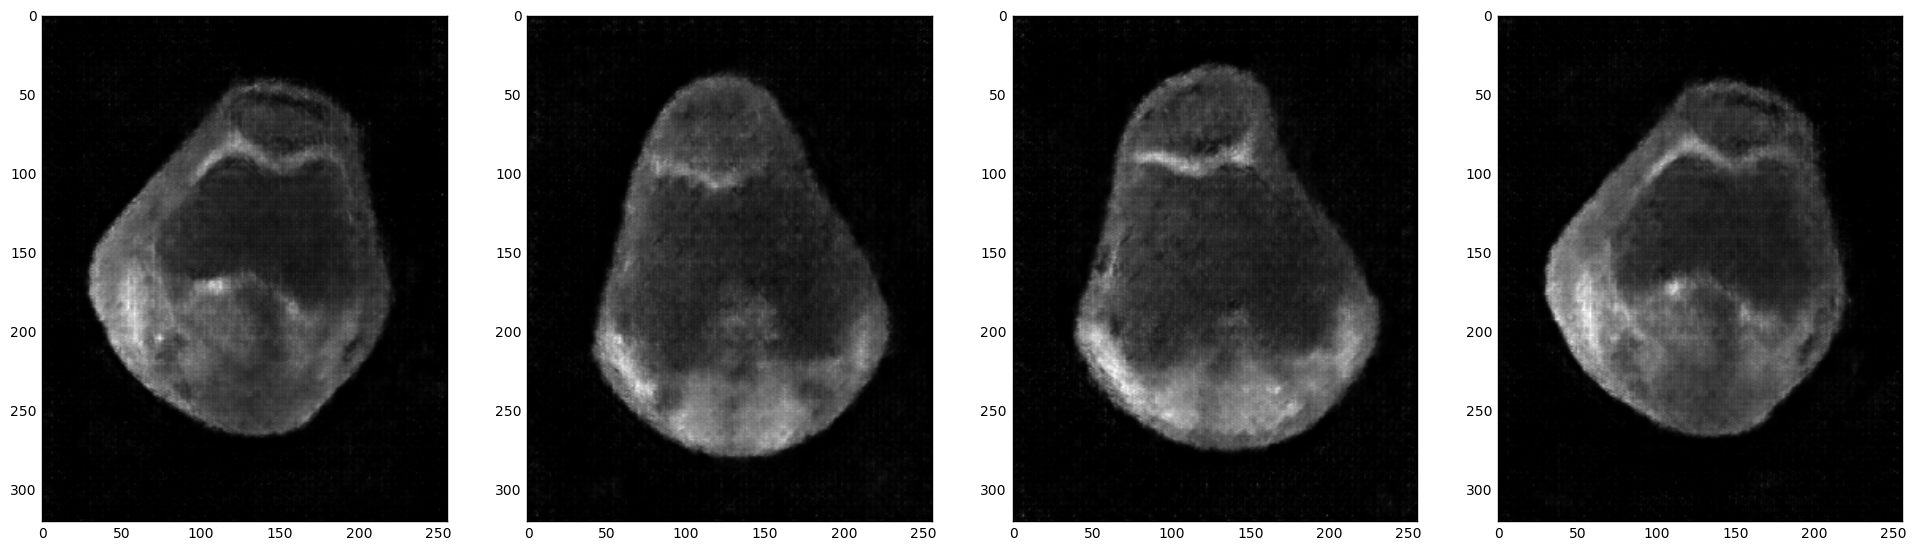

In [2]:
# ALL 4 simulataneously trained data[0:4] from valid
a = np.load('./data/recon_mri/4_original_test.npy')
b = np.load('./data/recon_mri/4_reconstructed_test.npy')

c1 = np.load('./data/recon_mri/1_reconstructed_test.npy')[0:1]
c2 = np.load('./data/recon_mri/1_reconstructed_test_2.npy')[1:2]
c3 = np.load('./data/recon_mri/1_reconstructed_test_3.npy')[2:3]
c4 = np.load('./data/recon_mri/1_reconstructed_test_4.npy')[3:4]

c = np.concatenate((c1, c2, c3, c4))
print(np.shape(c))
show_images(a)
show_images(b)
show_images(c)

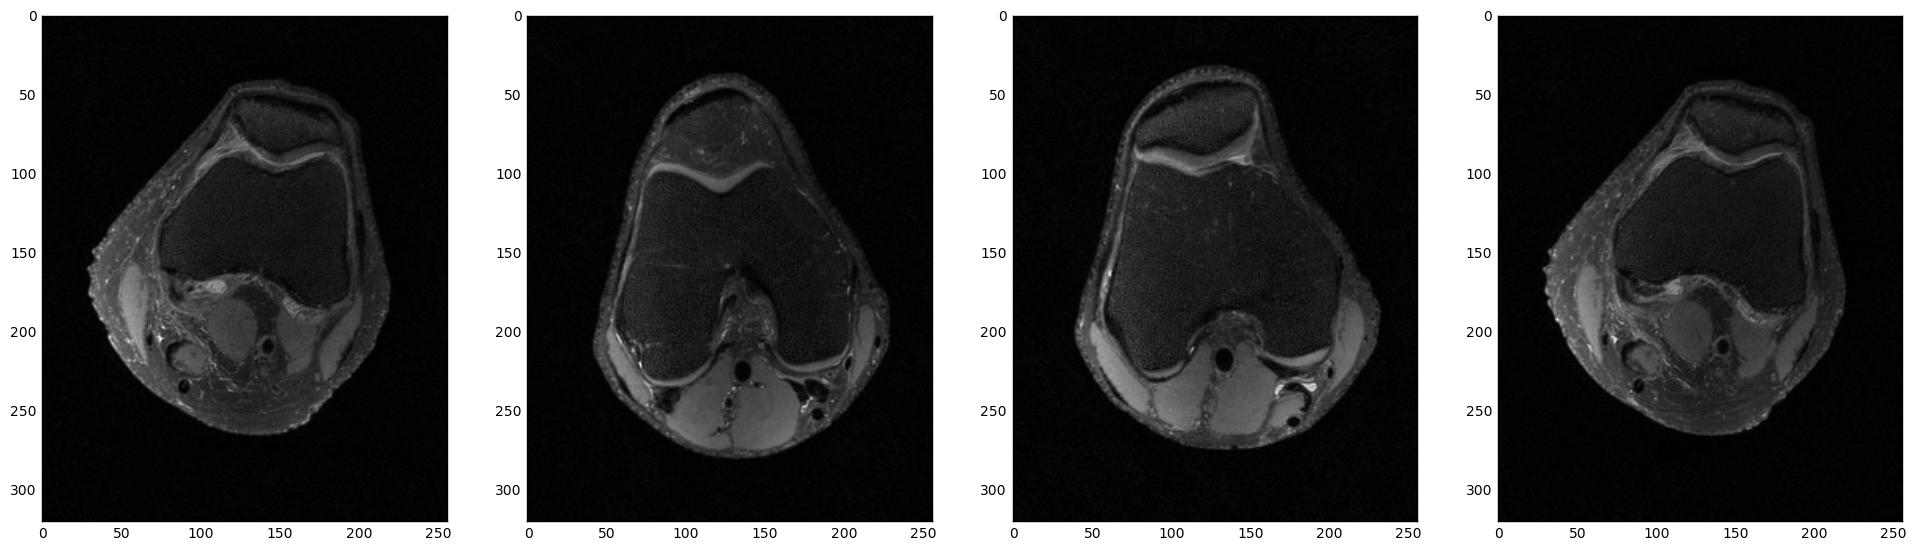

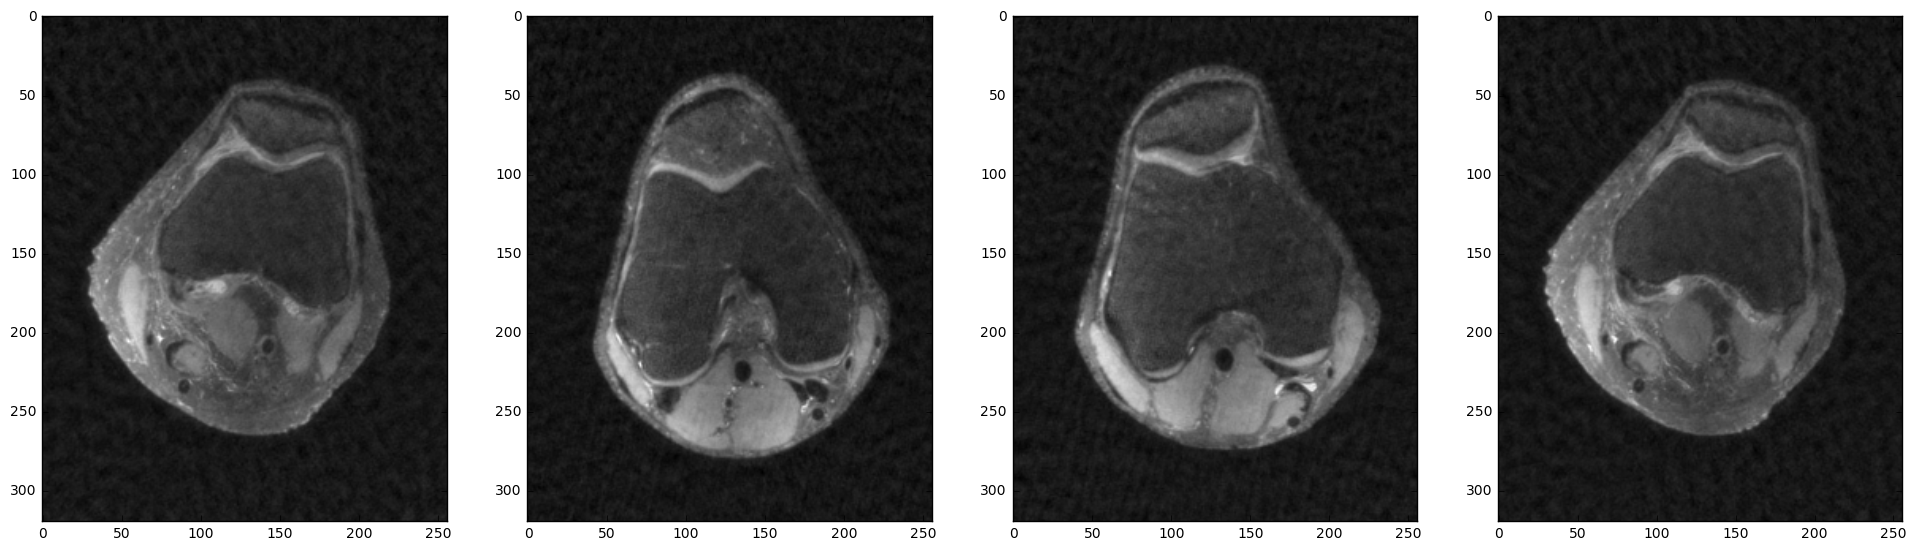

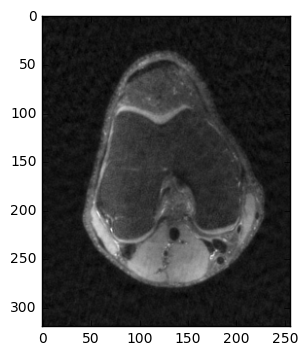

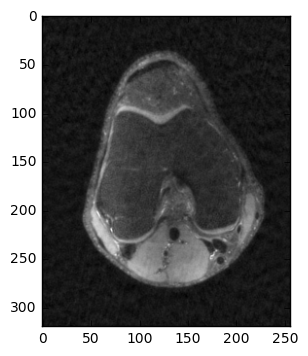

0.0101580990129


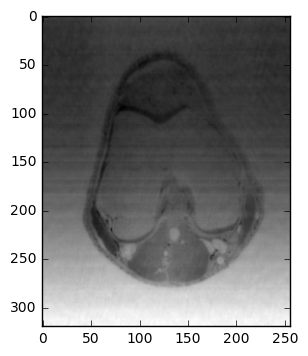

In [36]:
masks = glob("../masks/masks/*.ra")

img = ra.read_ra(masks[1]).T
mag = abs(img)
mag = (mag > 0.5)*1.

the_mask = np.fft.fftshift(mag)

#data = glob("./img_align_celeba/*.jpg")[3005:3009] #face
data = glob("../data/valid_img_slices/*.ra")         #mri
#np.random.shuffle(data)

sample_files = data[0:4]
#sample = [get_image_old1(sample_file, True) for sample_file in sample_files] #face
#sample = [cv2.resize(s, dsize=(256, 320)) for s in sample]                   #face
sample = [get_image_old2(sample_file) for sample_file in sample_files]        #mri
show_images(sample)
with tf.Session() as sess:
    tff = tf.cast(np.array(sample), dtype=tf.complex64)
    ffts = tf.fft2d(tff).eval()
    masked = tf.multiply(ffts, the_mask)
    iffts = tf.real(tf.ifft2d(masked)).eval()
    show_images(iffts)
    plt.imshow(iffts[1], cmap='gray')
    plt.show()
#plt.imshow(iffts[0], cmap = 'gray')
#plt.show()

a = sample[1]
b = np.real(np.fft.ifft2(np.multiply(the_mask, np.fft.fft2(a))))
plt.imshow(b, cmap='gray')
plt.show()
print(np.amax(iffts[1] - b))
plt.imshow(iffts[1] - b, cmap='gray')
plt.show()

In [3]:
def poisson(img_shape, accel, K=30, calib=[0, 0], dtype=np.complex,
            crop_corner=True, return_density=False, seed=0):
    ''' Generate Poisson-disk sampling pattern

    Inputs
    ------
    img_shape - Length-2 array containing x and y dimensions
    a - Target acceleration factor. Greater than 1
    K - maximum number of samples to reject
    calib - calibration size
    '''

    y, x = np.mgrid[:img_shape[-2], :img_shape[-1]]
    x = np.maximum(abs(x - img_shape[-1] / 2) - calib[-1] / 2, 0)
    x /= x.max()
    y = np.maximum(abs(y - img_shape[-2] / 2) - calib[-2] / 2, 0)
    y /= y.max()
    r = np.sqrt(x ** 2 + y ** 2)

    slope_max = 40
    slope_min = 0
    while slope_min < slope_max:
        slope = (slope_max + slope_min) / 2.0
        R = (1.0 + r * slope)
        mask = _poisson(img_shape[-1], img_shape[-2], K, R, calib, seed)
        if crop_corner:
            mask *= r < 1

        est_accel = img_shape[-1] * img_shape[-2] / np.sum(mask[:])

        if abs(est_accel - accel) < 0.1:
            break
        if est_accel < accel:
            slope_min = slope
        else:
            slope_max = slope

    mask = mask.reshape(img_shape).astype(dtype)
    if return_density:
        return mask, r
    else:
        return mask

def _poisson(nx, ny, K, R, calib, seed):
    '''
    img_dims - Length-2 array containing x and y dimensions
    a - Target acceleration factor. Greater than 1
    K - maximum number of samples to reject
    '''
    mask = np.zeros((ny, nx))
    f = ny / nx

    if seed is not None:
        np.random.seed(int(seed))

    pxs = np.empty(nx * ny, np.int32)
    pys = np.empty(nx * ny, np.int32)
    pxs[0] = np.random.randint(0, nx)
    pys[0] = np.random.randint(0, ny)
    m = 1
    while (m > 0):

        i = np.random.randint(0, m)
        px = pxs[i]
        py = pys[i]
        rad = R[py, px]

        # Attempt to generate point
        done = False
        k = 0
        while not done and k < K:

            # Generate point randomly from R and 2R
            rd = rad * math.sqrt(np.random.random() * 3 + 1)
            t = 2 * math.pi * np.random.random()
            qx = px + rd * math.cos(t)
            qy = py + rd * f * math.sin(t)

            # Reject if outside grid or close to other points
            if qx >= 0 and qx < nx and qy >= 0 and qy < ny:

                startx = max(int(qx - rad), 0)
                endx = min(int(qx + rad + 1), nx)
                starty = max(int(qy - rad * f), 0)
                endy = min(int(qy + rad * f + 1), ny)

                done = True
                for x in range(startx, endx):
                    for y in range(starty, endy):
                        if (mask[y, x] == 1 and
                            (((qx - x) / R[y, x]) ** 2 +
                             ((qy - y) / (R[y, x] * f)) ** 2 < 1)):
                            done = False
                            break

                    if not done:
                        break

            k += 1

        # Add point if done else remove active
        if done:
            pxs[m] = qx
            pys[m] = qy
            mask[int(qy), int(qx)] = 1
            m += 1
        else:
            pxs[i] = pxs[m - 1]
            pys[i] = pys[m - 1]
            m -= 1

    # Add calibration region
    mask[int(ny / 2 - calib[-2] / 2):int(ny / 2 + calib[-2] / 2),
         int(nx / 2 - calib[-1] / 2):int(nx / 2 + calib[-1] / 2)] = 1

    return mask

In [58]:
rands = np.random.randint(10000, size=20)
subs = [2, 4, 6]
for sub in subs:
    for i in range(20):
        mask = poisson([320, 256], sub, calib=[24, 24], seed=rands[i])
        np.save(("../masks/gen_masks/{}_").format(sub) + str(i), mask)

KeyboardInterrupt: 

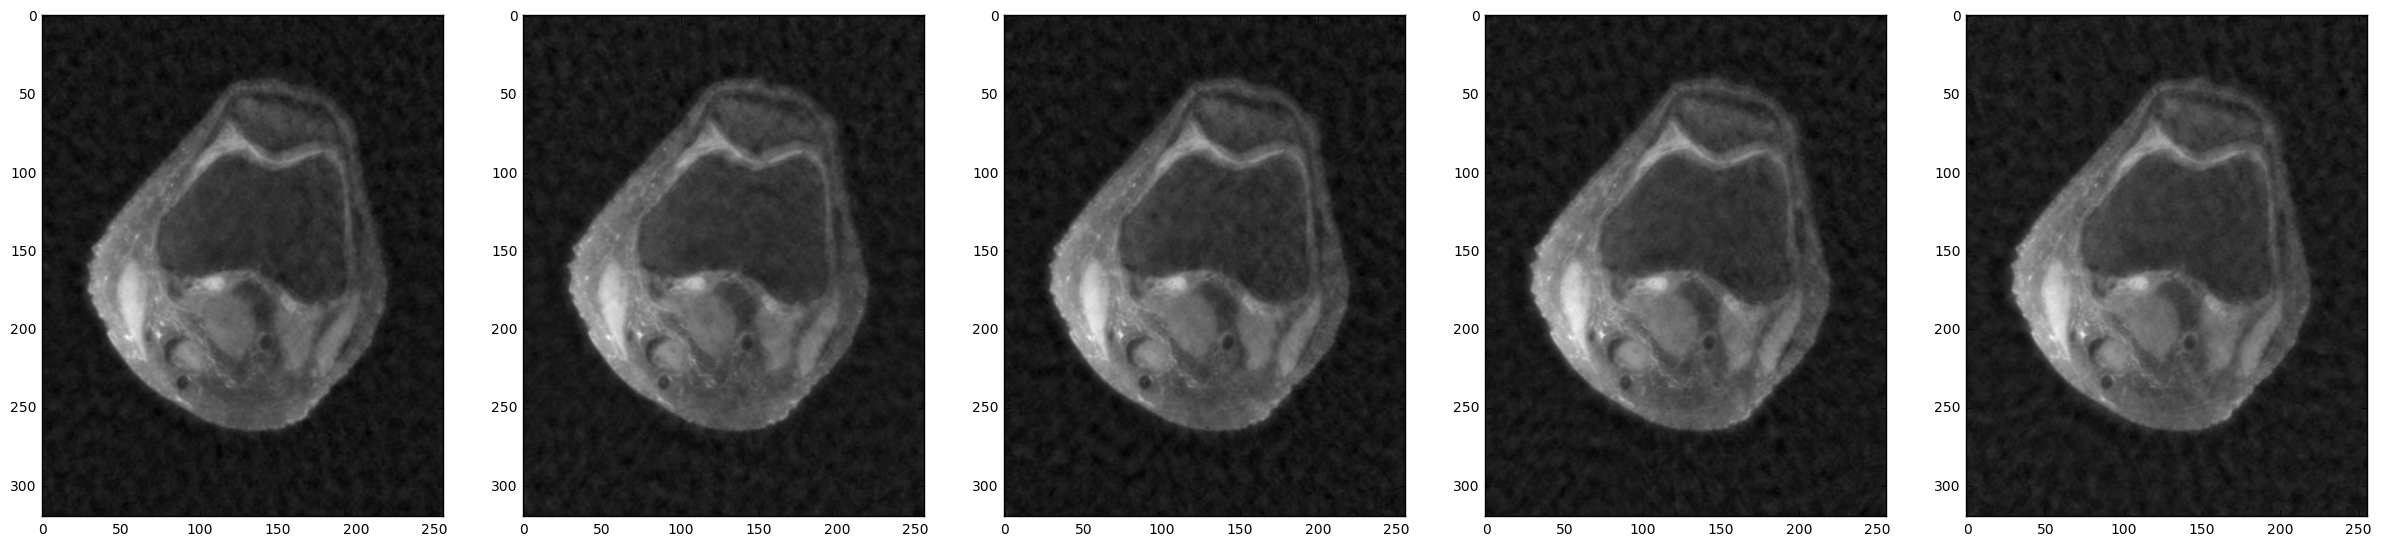

In [60]:
data = glob("../data/valid_img_slices/*.ra")         #mri
#np.random.shuffle(data)

masks = glob("../masks/masks/*.ra")

img = ra.read_ra(masks[1]).T
mag = abs(img)
mag = (mag > 0.5)*1.

the_mask = np.fft.fftshift(mag)

sample_files = data[0]
sample = get_image_old2(sample_files)        #mri
ffts = np.fft.fft2(sample)
imgs = []
dat = glob("../masks/gen_masks/4_*")
for i in range(5):
    #mask = np.fft.fftshift(poisson([320, 256], 4, calib=[24, 24], seed=np.random.randint(100)))
    #np.save("./gen_masks/4_" + str(i), mask)
    masked = np.multiply(ffts, np.fft.fftshift(np.load(dat[i])))
    iffts = np.fft.ifft2(masked)
    imgs.append(np.real(iffts))
show_images(imgs)

0.100308017374


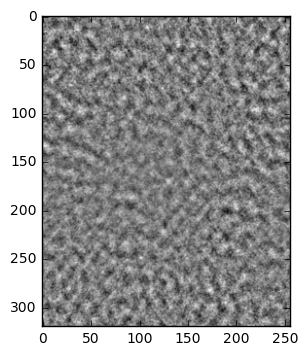

In [64]:
print(np.amax(imgs[4] - imgs[0]))
plt.imshow(imgs[1] - imgs[0], cmap='gray')
plt.show()

5000


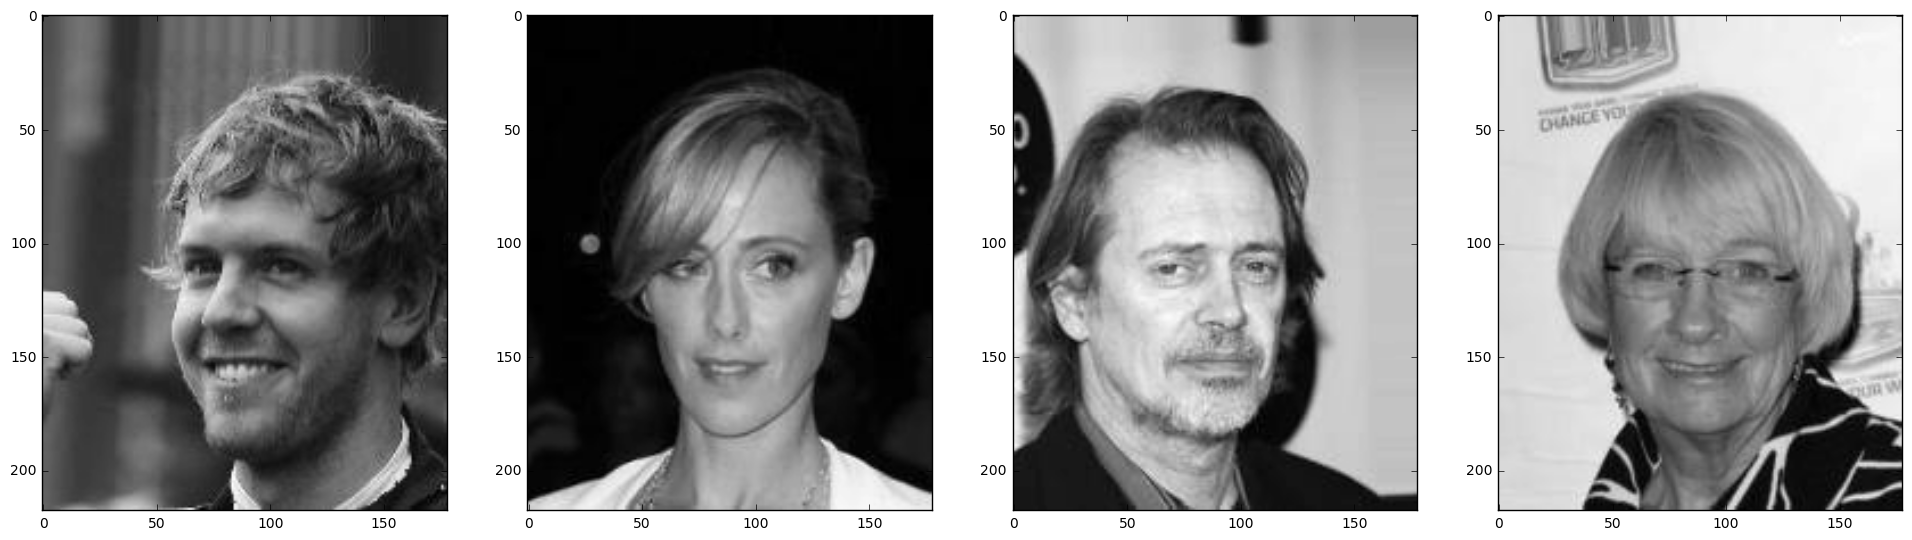

In [17]:
from skimage import io
import scipy.misc

data = glob("../celebA/*.jpg")
print(len(data))
show_images([get_image_old1(a, True) for a in data[3005:3009]])
#for a in data:
#    scipy.misc.imsave('../celebA/' + a[-10:], io.imread(a))
    
    
    

In [5]:
def imreadr(path, grayscale = False):
  return abs(ra.read_ra(os.path.join(path))).T

# gets one image from path, does not patch, puts between [-1, 1]  CURRENT METHOD FOR MRI  
def get_image_test(image_path):
  img = (ra.read_ra(os.path.join(image_path))).T
  test = np.zeros((320, 256, 2))
  test[:, :, 0] = np.real(img)
  test[:, :, 1] = np.imag(img)
  #image = [np.real(img), np.imag(img)]
  # a = (np.array(image) - 0.5) / 0.5 # *2 - 1
  return test
  #return np.reshape(test, (320, 256, 2))
def convert(img):
  test = np.zeros((320, 256, 2))
  test[:, :, 0] = np.real(img)
  test[:, :, 1] = np.imag(img)
  return test

(4, 320, 256)
(4, 320, 256)
(4, 320, 256, 2)


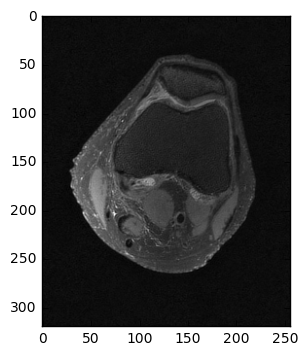

(-0.013599429279565801+0.0024373838678002557j)

In [7]:
data = glob("../data/valid_img_slices/*.ra")         #mri
sample_files = data[0:4]
sample = [get_image_test(a) for a in sample_files]         #mri
im = [a[:, :, 0] + 1j*a[:, :, 1] for a in sample]
print(np.shape(im))
#im = sample[0][:, :, 0] + 1j*sample[0][:, : , 1]
im = np.fft.fft2(im)
im = np.fft.ifft2(im)
print(np.shape(im))
fix = [convert(img) for img in im]
print(np.shape(fix))
plt.imshow(np.real(im[0]), cmap='gray')
plt.show()
np.amin(im[:, :, 0])